In [1]:
from pathlib import Path
import iris
import numpy as np
data_path = Path("data")

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [3]:
import pandas as pd

In [4]:
import cf_units
import datetime

In [5]:
cube = iris.load_cube(str(data_path / "erai_t2m.nc"))

In [6]:
cube.coord('time').units

Unit('months since 1979-01-15 00:00:00', calendar='proleptic_gregorian')

In [7]:
cube.coord('latitude').guess_bounds()
cube.coord('longitude').guess_bounds()
#cube.coord('time').convert_units('months since 1979-01-15')
tcoord = cube.coord('time')
print(tcoord.units.origin)
tcoord.units = cf_units.Unit(tcoord.units.origin, calendar='gregorian')
cube.coord('time').convert_units('seconds since 1979-01-15')

months since 1979-01-15 00:00:00


In [8]:
time = cube.coord('time')
print(repr(time.units))
print(time[:4])

Unit('seconds since 1979-01-15', calendar='gregorian')
DimCoord([1979-01-15 00:00:00, 1979-02-14 10:29:04, 1979-03-16 20:58:08,
       1979-04-16 07:27:11], standard_name='time', calendar='gregorian', var_name='time')


In [9]:
#time_unit = cf_units.Unit('hours since 1979-01-15 00:00:00', calendar='proleptic_gregorian')
#time_unit

In [10]:
#date_indexes = pd.date_range(start='1/15/1979', periods=484, freq=pd.DateOffset(months=1))
#date_indexes

In [11]:
#new_date_points = [time_unit.date2num(new_date) for new_date in date_indexes]
#new_time_coord = iris.coords.DimCoord(new_date_points, standard_name='time', units=time_unit)

In [12]:
#time_coord_dims = cube.coord_dims('time')
#cube.remove_coord('time')
#cube.add_dim_coord(new_time_coord, time_coord_dims)

In [13]:
cube

<iris 'Cube' of t2m / (K) (time: 484; latitude: 256; longitude: 512)>

In [14]:
for cord in cube.coords():
    print(cord.standard_name)
    print(repr(cord.units))
    print(repr(cord.shape))
    print('--------------------------')

time
Unit('seconds since 1979-01-15', calendar='gregorian')
(484,)
--------------------------
latitude
Unit('degrees')
(256,)
--------------------------
longitude
Unit('degrees')
(512,)
--------------------------


In [15]:
print(cube.units)
print(cube.name())
print(cube.ndim)
print(cube.shape)
#print(type(cube.data))

K
t2m
3
(484, 256, 512)


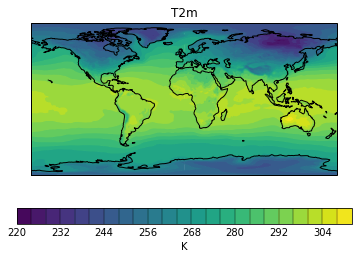

In [16]:
# Draw the contour with 25 levels.
qplt.contourf(cube[0], 25)
plt.gca().coastlines()
plt.show()

In [17]:
cube.convert_units('celsius')
print(cube.units)

celsius


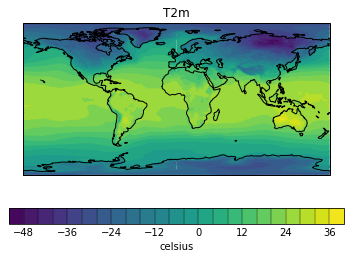

In [18]:
# Draw the contour with 25 levels.
qplt.contourf(cube[0], 25)
plt.gca().coastlines()
plt.show()

## Averaging

Some operators support additional keywords to the cube.collapsed method. For example, iris.analysis.MEAN supports a weights keyword which can be combined with iris.analysis.cartography.area_weights() to calculate an area average.

Let’s use the same data as was loaded in the previous example. Since grid_latitude and grid_longitude were both point coordinates we must guess bound positions for them in order to calculate the area of the grid boxes:

In [19]:
grid_areas = iris.analysis.cartography.area_weights(cube)

/home/fdiblen/.conda/envs/nso/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [20]:
new_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
new_cube

<iris 'Cube' of t2m / (celsius) (time: 484)>

# New coordinates
The Cube.aggregated_by operation combines data for all points with the same value of a given coordinate. 

The most common use is to aggregate data over regular time intervals, such as by calendar month or day of the week.

https://scitools.org.uk/iris/docs/v2.2.1/iris/iris/coord_categorisation.html#module-iris.coord_categorisation

Let’s create two new coordinates on the cube to represent the climatological seasons and the season year respectively:


In [21]:
import iris.coord_categorisation

In [22]:
iris.coord_categorisation.add_season(cube, 'time', name='clim_season')
iris.coord_categorisation.add_season_year(cube, 'time', name='season_year')

In [23]:
clim_season = cube.coord('clim_season')
print(clim_season.shape)
print(clim_season[0:5])

(484,)
AuxCoord(array(['djf', 'djf', 'mam', 'mam', 'mam'], dtype='<U64'), standard_name=None, units=Unit('no_unit'), long_name='clim_season')


In [24]:
season_year = cube.coord('season_year')
print(season_year.shape)
print(season_year[0:5])

(484,)
AuxCoord(array([1979, 1979, 1979, 1979, 1979]), standard_name=None, units=Unit('1'), long_name='season_year')


In [25]:
cube

<iris 'Cube' of t2m / (celsius) (time: 484; latitude: 256; longitude: 512)>

In [26]:
print(cube.shape)

(484, 256, 512)


In [27]:
print(cube[0, :].shape)

(256, 512)


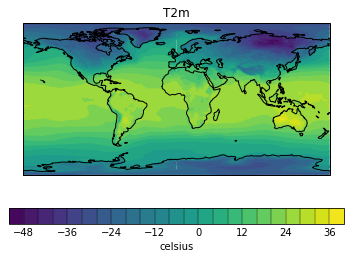

In [28]:
qplt.contourf(cube[0, :], 25)
plt.gca().coastlines()
plt.show()

In [29]:
print(cube[:].shape)

(484, 256, 512)


In [30]:
import iris.analysis
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

(484,)


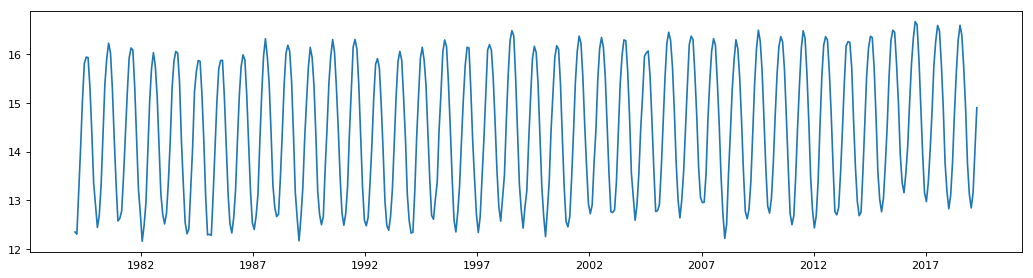

In [31]:
temp_mean = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
print(temp_mean.shape)

fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
iplt.plot(temp_mean)
plt.show()

/home/fdiblen/.conda/envs/nso/lib/python3.7/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


(484,)


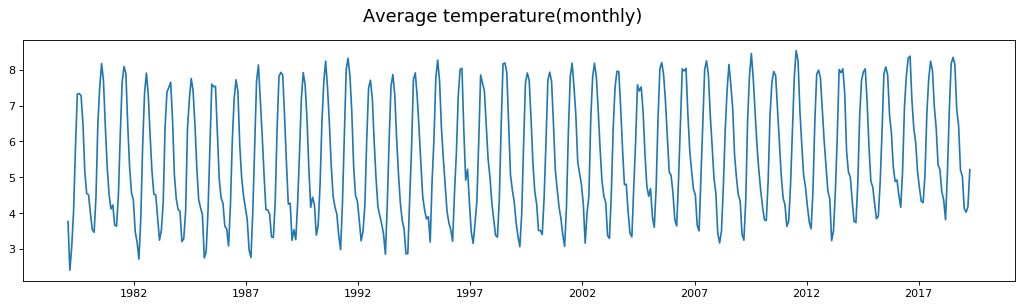

In [32]:
temp_mean = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN)
print(temp_mean.shape)

fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Average temperature(monthly)', fontsize=16)

iplt.plot(temp_mean)
plt.show()

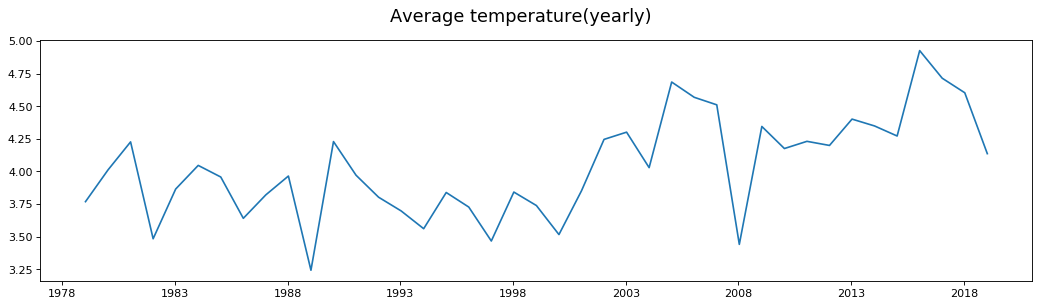

In [33]:
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Average temperature(yearly)', fontsize=16)

iplt.plot(temp_mean[::12])
plt.show()

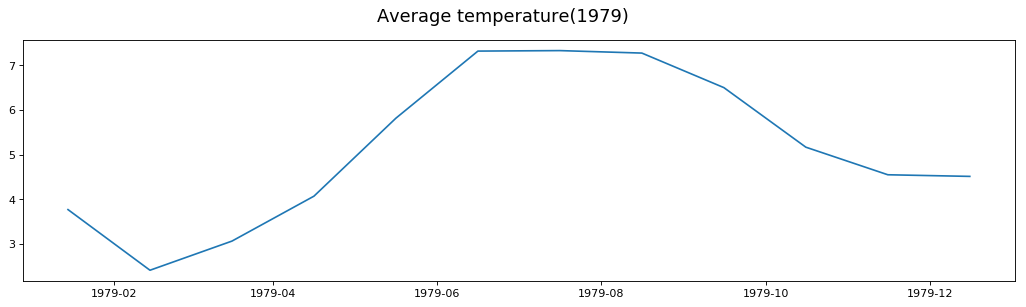

In [34]:
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Average temperature(1979)', fontsize=16)

iplt.plot(temp_mean[:12])
plt.show()

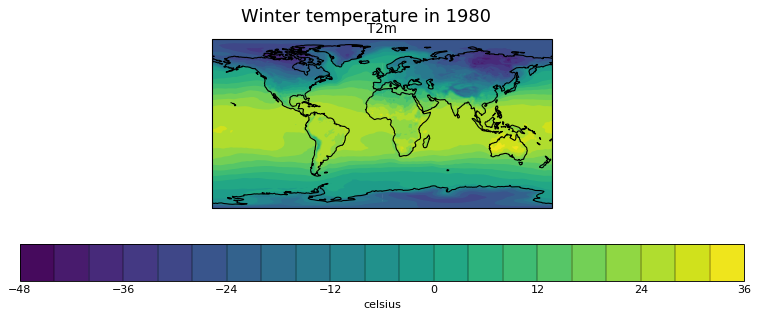

In [35]:
constraint = iris.Constraint(clim_season='djf', season_year=1980)
winter = cube.extract(constraint)
# print(winter)

fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Winter temperature in 1980', fontsize=16)

qplt.contourf(winter[1, :], 25)
plt.gca().coastlines()
plt.show()

# Season data

The primary change in the cube is that the cube’s data has been reduced in the ‘time’ dimension by aggregation (taking means, in this case). This has collected together all datapoints with the same values of season and season-year. The results are now indexed by the 19 different possible values of season and season-year in a new, reduced ‘time’ dimension.

In [36]:
annual_seasonal_mean = cube.aggregated_by(
     ['clim_season', 'season_year'],
     iris.analysis.MEAN)
annual_seasonal_mean

<iris 'Cube' of t2m / (celsius) (time: 162; latitude: 256; longitude: 512)>

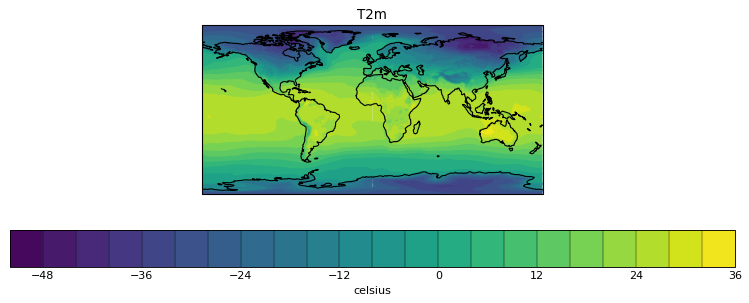

In [37]:
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')

qplt.contourf(annual_seasonal_mean[0, :], 25)
plt.gca().coastlines()
plt.show()

In [38]:
print(type(annual_seasonal_mean))

<class 'iris.cube.Cube'>


# Machine Learning

In [39]:
from iris.pandas import as_cube, as_series, as_data_frame

In [40]:
print(cube.data.shape)
print(cube.coords)
coord_names = [coord.name() for coord in cube.coords()]
print(', '.join(coord_names))

(484, 256, 512)
<bound method Cube.coords of <iris 'Cube' of t2m / (celsius) (time: 484; latitude: 256; longitude: 512)>>
time, latitude, longitude, clim_season, season_year


# https://facebook.github.io/prophet

In [41]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [42]:
# Create a new DataFrame with which we will create/train our Prophet model 
df = pd.DataFrame()

In [43]:
temp_mean

<iris 'Cube' of t2m / (celsius) (time: 484)>

In [44]:
UTC_format = '%Y-%m-%d'

mean_times = temp_mean.coord('time')
new_date_points = [mean_times.units.num2date(mean_times.points[date_index]).strftime(UTC_format) for date_index in range(mean_times.points.size)]
#new_date_points[:20]

In [45]:
print(len(new_date_points))
print(len(temp_mean.data))

484
484


In [46]:
df['ds'] = new_date_points

In [47]:
df['y'] = temp_mean.data

In [48]:
df.shape

(484, 2)

In [49]:
m = Prophet(seasonality_mode='multiplicative').fit(df[:-40])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


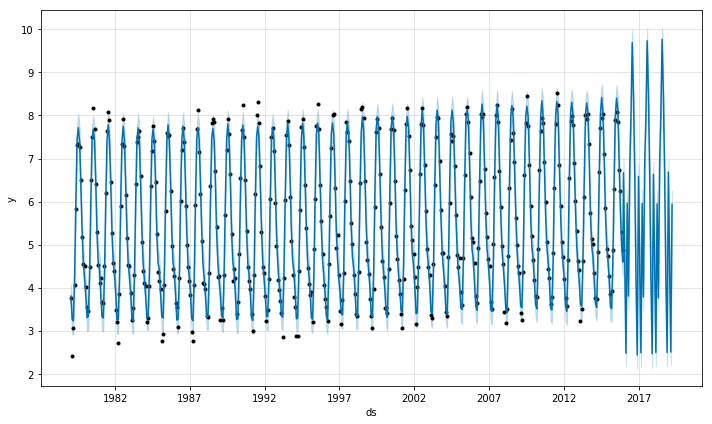

In [50]:
future = m.make_future_dataframe(periods=40, freq='M')
fcst = m.predict(future)

fig = m.plot(fcst)

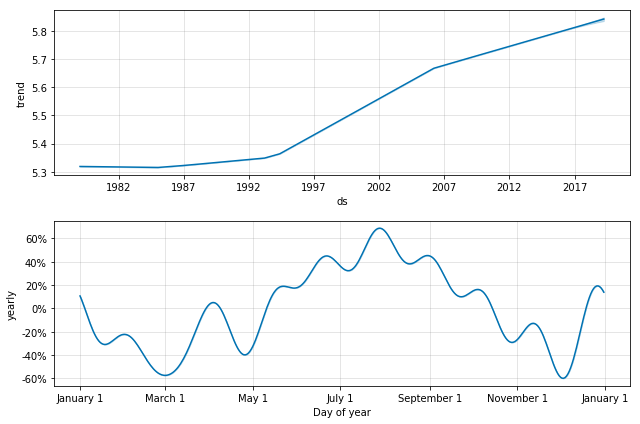

In [51]:
fig2 = m.plot_components(fcst)

In [52]:
fcst

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1979-01-15  5.318686    3.488112    4.080423     5.318686     5.318686   
1   1979-02-14  5.318636    2.920700    3.603850     5.318636     5.318636   
2   1979-03-16  5.318586    2.908886    3.528425     5.318586     5.318586   
3   1979-04-16  5.318534    3.938842    4.604173     5.318534     5.318534   
4   1979-05-16  5.318484    5.682897    6.318844     5.318484     5.318484   
..         ...       ...         ...         ...          ...          ...   
479 2018-11-30  5.837127    2.170986    2.808103     5.831314     5.842160   
480 2018-12-31  5.838260    6.338532    6.977089     5.832140     5.843498   
481 2019-01-31  5.839394    4.219750    4.847742     5.832844     5.844736   
482 2019-02-28  5.840418    2.202654    2.846034     5.833676     5.846002   
483 2019-03-31  5.841551    5.643411    6.248408     5.834612     5.847438   

     multiplicative_terms  multiplicative_terms_lower  \
0               -0.284971                   -0.284971   
1               -0.384142                   -0.384142   
2               -0.393162                   -0.393162   
3               -0.197514                   -0.197514   
4                0.130297                    0.130297   
..                    ...                         ...   
479             -0.572877                   -0.572877   
480              0.144865                    0.144865   
481             -0.224123                   -0.224123   
482             -0.571253                   -0.571253   
483              0.016348                    0.016348   

     multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                     -0.284971 -0.284971     -0.284971     -0.284971   
1                     -0.384142 -0.384142     -0.384142     -0.384142   
2                     -0.393162 -0.393162     -0.393162     -0.393162   
3                     -0.197514 -0.197514     -0.197514     -0.197514   
4                      0.130297  0.130297      0.130297      0.130297   
..                          ...       ...           ...           ...   
479                   -0.572877 -0.572877     -0.572877     -0.572877   
480                    0.144865  0.144865      0.144865      0.144865   
481                   -0.224123 -0.224123     -0.224123     -0.224123   
482                   -0.571253 -0.571253     -0.571253     -0.571253   
483                    0.016348  0.016348      0.016348      0.016348   

     additive_terms  additive_terms_lower  additive_terms_upper      yhat  
0               0.0                   0.0                   0.0  3.803015  
1               0.0                   0.0                   0.0  3.275526  
2               0.0                   0.0                   0.0  3.227522  
3               0.0                   0.0                   0.0  4.268047  
4               0.0                   0.0                   0.0  6.011466  
..              ...                   ...                   ...       ...  
479             0.0                   0.0                   0.0  2.493170  
480             0.0                   0.0                   0.0  6.684021  
481             0.0                   0.0                   0.0  4.530653  
482             0.0                   0.0                   0.0  2.504063  
483             0.0                   0.0                   0.0  5.937047  

[484 rows x 16 columns]

In [53]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [54]:
cross_validation_results = cross_validation(model=m, initial=np.timedelta64(420, 'M'), period=np.timedelta64(20, 'M'), horizon=np.timedelta64(20, 'M'))
cross_validation_results.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-04-15 06:18:00 and 2014-04-15 06:18:00


ds      yhat  yhat_lower  yhat_upper         y              cutoff
0 2014-05-16  6.590137    6.280361    6.888381  6.681448 2014-04-15 06:18:00
1 2014-06-15  8.094339    7.801355    8.415262  7.699981 2014-04-15 06:18:00
2 2014-07-16  8.500000    8.184761    8.805945  7.935426 2014-04-15 06:18:00
3 2014-08-15  8.129332    7.828357    8.432493  8.024543 2014-04-15 06:18:00
4 2014-09-14  7.041670    6.731817    7.355101  7.103222 2014-04-15 06:18:00

In [55]:
performance_metrics_results = performance_metrics(cross_validation_results)
performance_metrics_results.head()

horizon       mse      rmse       mae      mape  coverage
0  60 days 17:42:00  0.081928  0.286231  0.242834  0.032441       0.5
1  91 days 17:42:00  0.237131  0.486961  0.479466  0.061181       0.0
2 121 days 17:42:00  0.164862  0.406032  0.334681  0.042102       0.5
3 151 days 17:42:00  0.007385  0.085934  0.083171  0.010862       1.0
4 182 days 17:42:00  0.006570  0.081056  0.079128  0.012583       1.0

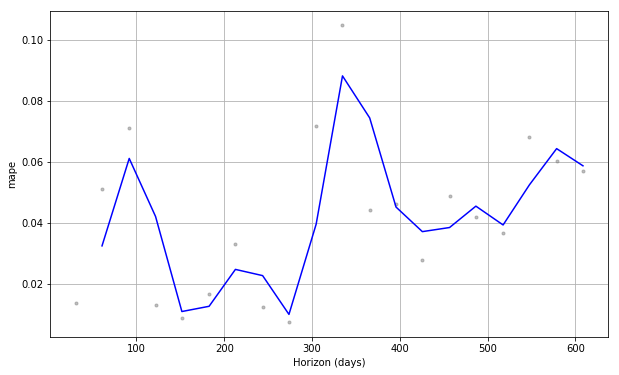

In [56]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cross_validation_results, metric='mape')